# CHAPTER 08

### 8.1 어텐션의 구조

**어텐션 메커니즘** 덕분에 seq2seq은 (인간처럼) 필요한 정보에만 주목할 수 있게 됨

#### seq2seq의 문제점
- 고정길이의 벡터 문제<br>
아무리 긴 문장이 입력되더라도 항상 똑같은 길이의 벡터에 밀어넣어야함

#### Encoder 개선
Encoder 출력의 길이를 입력 문장의 길이에 따라 바꿔줌

#### Decoder 개선
**[Attention Weight 계층 구현]**<br>
'입력과 출력의 여러 단어 중 어떤 단어끼리 서로 관련되어 있는가'라는 대응관계를 seq2seq에게 학습시킬수는 없을까?<br>
목표: 도착어 단어와 대응 관계에 잇는 출발어 단어의 정보를 골라내는 것, 그 정보를 이용하여 번역을 수행하는 것

1. 각 단어에 대한 가중치를 구한다
2. 가중합을 계산하여 맥락 벡터를 구한다

**[Weight Sum 계층 구현]**<br>
각 단어의 중요도를 나타내는 가중치 a가 있다면, 가중합을 이용해 맥락 벡터를 얻을 수 있다. <br>
그렇다면 **a**는 어떻게 구할까?

1. 내적을 통해 hs의 각 행과 h의 유사도를 산출
2. Softmax를 통한 정규화

**[두 계층을 결합]**<br>
![1](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fp8BkK%2FbtqKjcbcTP6%2FYAuWZKHxcthUkuWLvOVZnK%2Fimg.png)

**[다수의 Attention 계층을 Time Attention 계층으로서 모아 구현]**<br>


### 8.2 어텐션을 갖춘 seq2seq 구현

In [1]:
# 구현
import sys
sys.path.append("C:/Users/minjuKim/Desktop/[FIN_AI]_study_myself/deep-learning-from-scratch-2-master")
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention


class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads


| 에폭 1 |  반복 1 / 351 | 시간 1[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 26[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 53[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 78[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 105[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 131[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 158[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 186[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 213[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 240[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 267[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 293[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 318[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 344[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 371[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 398[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 423[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 449[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
X 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1978-08-11
---
Q Tuesday, Nove

Q october 6, 1992              
T 1992-10-06
O 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
O 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
O 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
O 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
O 2016-11-06
---
정확도 99.940%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 15[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 30[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 45[s] | 손실 0.00
| 에폭 7 |  반복 81 / 351 | 시간 60[s] | 손실 0.00
| 에폭 7 |  반복 101 / 351 | 시간 76[s] | 손실 0.00
| 에폭 7 |  반복 121 / 351 | 시간 91[s] | 손실 0.00
| 에폭 7 |  반복 141 / 351 | 시간 106[s] | 손실 0.00
| 에폭 7 |  반복 161 / 351 | 시간 120[s] | 손실 0.00
| 에폭 7 |  반복 181 / 351 | 시간 135[s] | 손실 0.00
| 에폭 7 |  반복 201 / 351 | 시간 150[s] | 손실 0.00
| 에폭 7 |  반복 221 / 351 | 시간 165[s] | 손실 0.00
| 에폭 7 |  반복 241 / 351 | 시간 180[s] | 손실 0.00
| 에폭 7 |  반복 261 / 351 | 시간 199[s] | 손실 0.00
| 에폭 7 |  반복 281 / 351 | 시간 222[s] | 손실 0.00
| 에폭 7 |  반복 301 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50640 missing from c

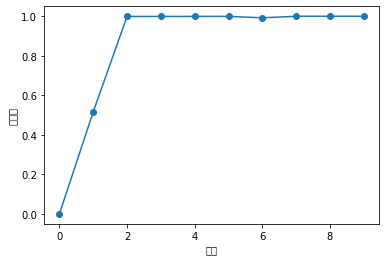

In [3]:
#학습

sys.path.append('C:/Users/minjuKim/Desktop/[FIN_AI]_study_myself/deep-learning-from-scratch-2-maste/ch07')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

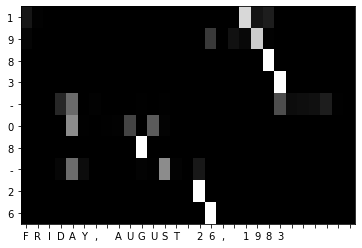

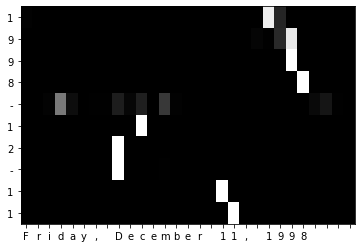

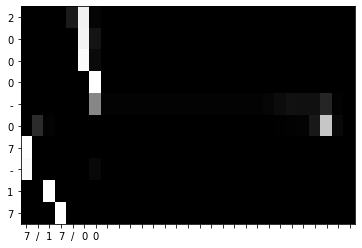

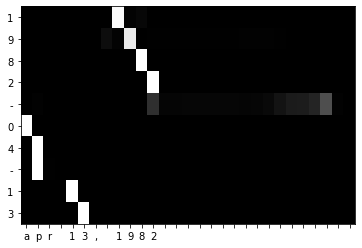

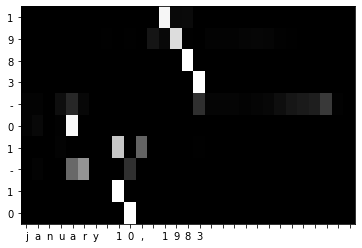

In [5]:
#어텐션 시각화
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt
from ch08.attention_seq2seq import AttentionSeq2seq


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

### 8.4 어텐션에 관한 남은 이야기

#### 양방향 RNN 
양방향 LSTM에서는 지금까지의 LSTM 계층에 더해 역방향으로 처리하는 LSTM 계층도 추가함. 각 시각에서는 이 두 LSTM 계층의 은닉상태를 연결 시킨 벡터를 최종 은닉상태로 처리함.<br>
이처럼 양방향으로 처리함으로써, 각 단어에 대응하는 은닉 상태 벡터에는 좌와 우 양쪽 방향으로 정보를 집약할 수 있고, 균형잡힌 정보의 인코딩 가능


### 정리
- 번역이나 음성 인식 등, 한 시계열 데이터를 다른 시계열 데이터로 변환하는 작업에서 시계열 데이터 사이의 대응 관계가 존재하는 경우가 많다.
- 어텐션은 두 시계열 데이터 사이의 대응관계를 데이터로부터 학습한다.
- 어텐션에서는 (하나의 방법으로서) 벡터의 내적을 사용해 벡터 사이의 유사도를 구하고, 그 유사도를 이용한 가중합 벡터가 어텐션의 출력이 된다.
- 어텐션에서 사용하는 연산은 미분 가능하기 때문에 오차역전파법으로 학습할 수 있다.
- 어텐션이 산출하는 가중치(확률)를 시각화 하면 입출력의 대응 관계를 볼 수 있다.
- 외부 메모리를 활용한 신경망 확장 연구 예에서는 메모리를 읽고 쓰는 데 어텐션을 사용했다.